In [1]:
from __future__ import division
from __future__ import absolute_import
from __future__ import print_function

import pickle

import tensorflow as TF
from tensorflow.python.client import device_lib
import numpy as np
import sys
sys.path.insert(0, "/home/groups/song/songlab2/somangk2/jupyter/jupyter/TERT/maxEnt-master")
sys.path.insert(0, "/home/groups/song/songlab2/somangk2/jupyter/jupyter/PrimeEditor/Theano-1.0.5")
sys.path.insert(0 , "/home/groups/song/songlab2/shared/Somang_Alex_share/interpret/scripts")
from motifUtils import plot_sNTdistrib, writeMotif_memeFormat, KLdiv_fromSamples
import os; 
os.environ['KERAS_BACKEND'] = 'theano'
import keras
from maxEnt import MEutils
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Concatenate,Input, concatenate, Dropout
from keras.optimizers import SGD
import keras.backend as K
from keras.utils import multi_gpu_model
from keras import backend as K
from keras.engine.base_layer import Layer
from keras.engine.base_layer import InputSpec
from keras.utils import conv_utils
from keras.legacy import interfaces
from keras.layers import Layer
import numpy
from random import shuffle
import os
from os import listdir
from os.path import isfile, join
from operator import itemgetter
import time
import scipy.stats

import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams["axes.labelsize"]="xx-large"
mpl.rcParams["xtick.labelsize"]="xx-large"
mpl.rcParams["ytick.labelsize"]="xx-large"
mpl.rcParams["legend.fontsize"]="xx-large"



/home/apps/software/Tensorflow-GPU/1.5.1-IGB-gcc-4.9.4-Python-3.6.1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:493: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/apps/software/Tensorflow-GPU/1.5.1-IGB-gcc-4.9.4-Python-3.6.1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:494: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/apps/software/Tensorflow-GPU/1.5.1-IGB-gcc-4.9.4-Python-3.6.1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:495: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'

In [2]:
1==1

True

In [3]:
import pandas as pd

In [5]:
keras.__version__, TF.__version__

('2.3.1', '2.2.0')

In [9]:
from __future__ import division
import numpy as np
import keras 
import keras.backend as K
from keras.models import Model
import theano
import theano.tensor as T
from theano.tensor.shared_randomstreams import RandomStreams


class layerSampler(object):
    """
    Class for sampling constrained maxEnt distribution associated with a feed-forward 
    keras model. After initialization, perform interpretation with sample method.
    """
    def __init__(self , model, beta , mu ,layerIdx, outputUnitIdxs ,  
                debug = True, s_rng = None , seed = None):
        """
        Inputs: 
            model - keras sequential model
            beta - positive float
            mu - (float) natural logrithm of the ratio of G/C frequency genome wide to A/T frequency genome wide
            layerIdx - (int) index of the hidden layer whose activations constrain maxEnt distribution 
                            (should be the layer taken as input by the network's output layer)
            outputUnitIdxs- tuple  of indices of output untis . If length 1 then use weights of corresponding output unit
                            to scale distances  in space of penultimate acitvations . If length 2 then scale distances in 
                            space of penultimate acitvations by log( P(outputUnits[0] |x  ) / P(outputUnits[1] |x  ) 
                            where P( |x) denomts the class probability assigned by the network the interpreted input
        """
        
        self.inputT = model.input
        self.targetLayer = model.layers[layerIdx]
        if debug:
            print ("sampling using similarity of represtation at layer {:d} of type {}".format(layerIdx, 
                                                                                          type(self.targetLayer) ) )
        self.targetLayerT = self.targetLayer.output
        self.scaleT = self.getPenultimeDistanceScaleTensor(outputLayer = model.layers[layerIdx +1],  
                                                        outputUnitIdxs=  outputUnitIdxs)
        self.beta = beta
        self.mu = mu
        self.Model = Model(input = self.inputT , output= self.targetLayerT )  ## defines an op taking input layer tensor as input and returning the activation tensor for target hidden layer
        self.calcObjective = K.function(inputs= [self.inputT , K.learning_phase()] , outputs= [self.targetLayerT])
#         self.calcObjective = K.function(inputs= [self.inputT , K.learning_phase()] , outputs= [model.layers[len(model.layers)-2].output])

        if s_rng is None:
            s_rng =RandomStreams(seed = seed )
        self.s_rng = s_rng

    ### Helper methods #################################################
    def getPenultimeDistanceScaleTensor(self, outputLayer, outputUnitIdxs  ):
        """
        construct the 1d tensor used to scale penultimate activations when calculating distance
        Inputs:
            outputLayer - keras layer with .W attribute returning symbolic variable of weights
             outputUnitIdxs  - see __init__ 
        outputs:
            scaleT - 1d tensor scaling penutimate activations 
        """
        if len(outputUnitIdxs) ==1:
             scaleT = outputLayer.kernel[:,0]#[:,outputUnitIdxs[0]]
        else:
            assert len(outputUnitIdxs)==2 , "length of ouputUnitIdxs must be 1 or 2"
            scaleT = outputLayer.kernel[:, outputUnitIdxs[0]] - outputLayer.kernel[:, outputUnitIdxs[1]]
        return scaleT
    
    def reshapeSamplingOutput(self, samplingOutput , nbInterpInputs , chainsPerInput  ):
        """
        Reshape samplingOutput ordered by timestep, then chainIndex to array ordered by interpretedInput (ax0), then
        by chainIndex and timestep (with timestep dominating chainIdex in determining ordering) (ax1).
        Inputs:
            samplingOutput - (nbSamplesPerChain , nbChains ,  1 , seqLen ) array where samplingOutput[i,j,0,:]
                             returns ith sample collected for jth chain
            nbInterpInputs - (int) number of interpreted inputs ,
            chainsPerInput  - (int) number chain per interpreted input
            seqLen - lenght of the last axis of samplingOutput
        Outputs:
            samplesByInterpInput - (nbInterpInputs , chainsPerInput*samplesPerChain , seqLen )
                                    where for samples collected with x chains for input sampletime j for chain k
                                    associated with  inpterpreted input i is given by
                                    samplesByInterpInput[i , x*j + k , :]                           
        """
        samplingOutput = np.squeeze(samplingOutput)
        samplesPerChain , _  , seqLen = samplingOutput.shape 
        ## split axis 1 into two axes indexing network input and chain assocaited with the input
        samplingOutput = samplingOutput.reshape(( samplesPerChain ,         #  samplingOut[i,j,k ,:] stores
                                                        nbInterpInputs ,           # sample at ith timepoint of kth chain
                                                        chainsPerInput,            # associated with jth interpreted input
                                                        seqLen ) , order = 'C')
        ## collapse axes indexing chains sampling time and chains assocaited with given input into a single axes
        ## ordered by time and then by chain index
        samplesByInterpInput = (samplingOutput.swapaxes(0,1)).reshape((nbInterpInputs, samplesPerChain*chainsPerInput,
                                                                      seqLen) , order = 'C')
        return  samplesByInterpInput    
    
    #### Methods defining symbolic operations of MCMC step ##############################
    
    def getProposedStates(self, states, ntIdxs, s_rng , moves):
        """
        sample proposed states given the current states described by variables states and ntIdxs
        Inputs:
            states - symbolic variable  (nbInputs , 1, seqLen,4) 
            ntIdxs  - symbolic variable (nbInputs , 1,seqLen) 
                    indexing the type of nucleotide as each sequence position
            ntCounts - symbolic variable (nbInputs , 4)  storing the counts of each 
                        nucleotide type each MCMC chain being run
            s_rng- theano.tensor.shared_randomstreams object
            moves - (4,4) float tensor where moves[i] stores the 4 input unit
                        activations encoding nucleotide of type i
        Returns:
            states_proposed -  symbolic variable  (nbInputs , 1, seqLen,4) 
            ntIdxs_proposed -  symbolic variable (nbInputs , 1,seqLen) 
            ntCounts_incr - symbolic variable (nbInputs , 4) (elements are 1 , -1 , 0) indicated the increments to counts
                            of each type of nucleotide associated with the proposed mutation     
        """
        idxs2Mutate = s_rng.random_integers(size =(states.shape[0] , ) ,low =  0 ,  
                                         high= states.shape[-2]-3 )  ## the sequence positions at which mutations are proposed.
        idxs2Mutate = T.concatenate([T.arange(states.shape[-2]-22),T.arange(states.shape[-2]-20,states.shape[-2])])[idxs2Mutate]
        
        ntPermInts =  s_rng.random_integers(size =(states.shape[0] , ) ,low =  1 ,
                                           high = states.shape[-1] -2 ) ## sample integers that will be used to permute the nucleotide content at positions selected for mutation
        ## get the indices of the nucleotides before and after mutation
        mutatedNT_idxs_old = ntIdxs[T.arange(states.shape[0]), T.arange(1, dtype="int64"), idxs2Mutate] 
        mutatedNT_idxs_new = T.mod( ntPermInts +  mutatedNT_idxs_old  , 4)
        ## uptade description of the states
        ntIdxs_proposed =  T.set_subtensor( ntIdxs[T.arange(states.shape[0], dtype="int64") , T.arange(1, dtype="int64"),  idxs2Mutate] ,
                                          mutatedNT_idxs_new ) 
        states_proposed =  T.set_subtensor(states[T.arange(states.shape[0],dtype="int64") ,  T.arange(1, dtype="int64") ,  idxs2Mutate,:4 ],
                                          moves[mutatedNT_idxs_new])
        ## update the counts of each nucleotide type for each input
        ## approach is to convert the indices of mutated nucleotides to 1 hot encoding then use this to update
        ## the ntCounts matrix
        ntCounts_incr = T.extra_ops.to_one_hot( mutatedNT_idxs_new  , nb_class = 4, dtype  = "int32" ) - \
                            T.extra_ops.to_one_hot( mutatedNT_idxs_old  , nb_class = 4, dtype  = "int32" )
        return states_proposed, ntIdxs_proposed , ntCounts_incr 

    def metropolisAccept_proposal(self, E_incr, N_incr,  states_proposed ,  ntIdxs_proposed,
                                  states_current,  ntIdxs_current, E_current,
                                  beta, mu, s_rng):
        """
        Accept proposed mutations according to metropolis criteria
        Inputs
            E_incr : (ntInputs, ) symbolic variable storing Energy_proposed - Energy_current
            N_incr : (nbInputs) symbolic variable storing N_proposed - N_current where N denotes counts of a collection of
                    user specified nucleotides
            states_proposed(_current) - symbolic variable  (nbInputs , 1, seqLen,4) describing proposed (current) state
            ntIdxs_proposed(_current)  - symbolic vaiable (nbInputs , 1,seqLen) 
                                       indexing the type of nucleotide as each sequence position of proposed (current) state
            E_current :  (ntInputs, ) sybolic variables storing energy of the current states
            beta - scalar
            mu - scalar
        Returns
        """
        accept = T.gt(T.exp( -1.0*beta * E_incr + mu * N_incr ), s_rng.uniform(size=E_incr.shape) )
        ## construct tensors used to update states_current , ntIdxs_current and expFactor_current
        ## accept.dimshuffle(...) broadcasts the boolean array over all axis after axis 0
        state_current_new = T.switch(accept.dimshuffle( 0, *(('x',) * (states_current.ndim - 1)) ),
                                     states_proposed  , states_current )
        ntIdxs_current_new = T.switch(accept.dimshuffle( 0, *(('x',) * (ntIdxs_current.ndim - 1)) ),
                                      ntIdxs_proposed , ntIdxs_current )
        E_current_new = accept*E_incr + E_current ## using accept (1d array of 1 and 0 as mask)
    
        return state_current_new, ntIdxs_current_new, E_current_new
    
    def calcEnergy(self, hiddenAct, targetT , scaleT,  ):
        """
        hiddenAct - (nbInputs , nbHiddenUnits ) symbolic float matrix storing  hidden layer 
                        representation of MCMC samples
        targetT  -  (nbInputs , nbHiddenUnits ) shared float matrix storing the hidden layer
                        representations of interpreted inputs
        scaleT - (nbHiddenUnits,) 1d tensor defining elements-wise scaling factors 
                for hidden unit activations used for calculating weighted euclidean dist
        """
        energy = T.sqrt( 
                         T.sum( (scaleT*(  hiddenAct - targetT))**2.0 , axis = -1 ) 
                             )
        return energy   
        
    def MCMC_step(self, states_proposed, ntIdxs_proposed,
                   states_current, ntIdxs_current, 
                  E_current, ntCounts_incr ,
                  moves , targetT, constrained_ntIdxs  ):
        """
        given current and proposed states and current exponential factors.
            1. compute the exponential factors of the proposed state
            2. apply metropolis accept criteria to exponential factors of proposed and current
                states and get updated value of current states as well as updated values of
                exponential factors
            3. get updated proposed states 
            
        Inputs: 
            ntCounts_incr : symbolic variable (nbInputs , 4) (elements are 1 , -1 , 0) indicated the 
                        increments to counts of each type of nucleotide 
            constrained_ntIdxs : ivector (ie  a 1d array indexing nucleotides whose average sequence content is
                                            constrained via the parameter mu)
        """
        ## compute the exponential factors of the proposed state
        hiddenAct = self.Model(states_proposed)
#         hiddenAct = self.calcObjective([states_proposed,0])[0]
        E_incr = self.calcEnergy(hiddenAct, targetT , self.scaleT,  )  - E_current
        N_incr = T.sum(ntCounts_incr[:,constrained_ntIdxs] ,axis = -1 )
        ## apply metropolis accept criteria
        state_current_new, ntIdxs_current_new, E_current_new= self.metropolisAccept_proposal(E_incr, 
                                                                                        N_incr, 
                                                                                        states_proposed ,  
                                                                                        ntIdxs_proposed, 
                                                                                        states_current, 
                                                                                        ntIdxs_current, 
                                                                                        E_current,
                                                                                        self.beta, 
                                                                                        self.mu, 
                                                                                        self.s_rng)
        ## get updated proposed states 
        states_proposed_new, ntIdxs_proposed_new, ntCounts_incr_new = self.getProposedStates(state_current_new,
                                                                                      ntIdxs_current_new,
                                                                                         self.s_rng ,
                                                                                         moves)
        return  states_proposed_new, ntIdxs_proposed_new, state_current_new, ntIdxs_current_new,  E_current_new, ntCounts_incr_new 

    def get_samplingFunc(self ):
        """
        construct the theano function used to do sampling
        Note: current code assumes that nucleotide indices can be obtained from
            input layer activations by applying argmax to last axis 
        """
        ## set-up symbolic variables for inputs to theano function
        interpInputs = T.tensor4(name = "interpInputs")
        moves = T.matrix(name = "moves")
        constrained_ntIdxs  = T.ivector(name ="constrained_ntIdxs" )
        nbSteps = T.iscalar(name = 'nbSteps')
        samplePeriod = T.iscalar(name = 'samplePeriod')
    
        ## intialize the symbolic variables passed to scan
        ntIdxs_initial = T.argmax(interpInputs , axis = -1)
        targetT = self.Model(interpInputs) 
#         targetT = self.calcObjective([interpInputs,0])[0] 
        E_initial = self.calcEnergy(targetT , targetT , self.scaleT ) ## should be 0's
        ntCounts_incr_initial = T.zeros(shape = (interpInputs.shape[0] , 4) , dtype="int32" )
        
        results , updates = theano.scan(fn = self.MCMC_step ,
                                         outputs_info = [interpInputs , ntIdxs_initial , 
                                                        interpInputs , ntIdxs_initial ,
                                                        E_initial,  ntCounts_incr_initial ],
                                       non_sequences = [moves , targetT  , constrained_ntIdxs ],
                                       n_steps = nbSteps)
        samples = results[3][::samplePeriod, :,:]  ## get ntIdxs_current_new entry     
        samplingFunc = theano.function(inputs = [interpInputs , nbSteps, samplePeriod, constrained_ntIdxs , moves ,  K.learning_phase() ],
                                        outputs = samples , updates= updates , on_unused_input = 'ignore')
        return samplingFunc
          
    def sample(self, interpInputs, constrained_ntIdxs = np.array([0,1] , dtype = np.int32) 
               ,indices_allowed=None
               ,moves = np.eye(4, dtype= theano.config.floatX),
                nbSteps = 500 , samplePeriod =100,  chainsPerInput=1 ):
        """
        collect samples for a collection of inputs in interpInputs. 

        interpInputs - (nbInputs ,1, seqlen, 4)
        """
        ## inputs to sampling function are for the form [seq0_chain0, ... , seq0_chain_nbChains,
        ##  seq1_chain0_initital, ... , seq1_chain_nbChains_initial , ...]
        ## where for each k seqi_chaink is a copy of the sequence interpInputs[i]
        if indices_allowed is None:
            self.indices_allowed = np.arange(0, state_init.shape[2])
        else:
            self.indices_allowed = indices_allowed
        nbInterpInputs , _ , seqLen, _ = interpInputs.shape
        self.nbInputs = nbInterpInputs*chainsPerInput
        samplingInputs = np.repeat( interpInputs, repeats=chainsPerInput, axis = 0 ).astype(theano.config.floatX)
        samplingFunc = self.get_samplingFunc()
        samplingOutput = samplingFunc( samplingInputs, nbSteps ,                 ## samplingOutput[i,j,0,:]
                                      samplePeriod ,constrained_ntIdxs, moves, 0 )  ##  returns ith sample collected
                                                                                 ## for jth axis 0 entry of samplingInputs
        samplesByInterpInput = self.reshapeSamplingOutput(samplingOutput , nbInterpInputs , chainsPerInput )
    
        return  samplesByInterpInput 


In [43]:
np.eye(4)

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [3]:
nuc2vec={}
for i1,N1 in enumerate(["A","C","G","T"]):
        nuc2vec[N1]=i1

def seq2vec(seq):
    L=len(seq)
    vec=np.zeros((L,4))
    for i in range(L):
        j=nuc2vec[seq[i]]
        vec[i,j]=1
    return vec

def log_mse_loss(y_true,y_pred):
    log_mse = K.mean(K.square(K.log(y_pred+1)-K.log(y_true+1)),axis=-1)
    return log_mse

In [4]:
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams["axes.labelsize"]="xx-large"
mpl.rcParams["xtick.labelsize"]="xx-large"
mpl.rcParams["ytick.labelsize"]="xx-large"
mpl.rcParams["legend.fontsize"]="xx-large"

In [5]:
wholeDF = pickle.load(open("/home/groups/song/songlab2/somangk2/jupyter/jupyter/PrimeEditor/wholeDF.pkl","rb"))
tmpDF = wholeDF
seqs = list(set(tmpDF.iloc[:,2]))

filepath="/home/groups/song/songlab2/somangk2/jupyter/jupyter/PrimeEditor/NN/filter40/test0/"
[train_seqs, vald_seqs, test_seqs] = pickle.load(open(filepath+"index.pkl","rb"))

ERdf = {}
for seq in seqs:
    ERdf[seq] = tmpDF[tmpDF.iloc[:,2]==seq][["PBS length", "RT length", "Measured PE efficiency"]]
seq_arrays = {}
ERs = {}
data_lst = {}
for S, seqs in zip(["train","test","vald"],[train_seqs, test_seqs, vald_seqs]):
    seq_arrays[S] = []
    ERs[S] = []
    for seq in seqs:
        seq_array = seq2vec(seq).reshape((1,47,4))
        for PBS, RT, ER in zip(ERdf[seq]["PBS length"], ERdf[seq]["RT length"], ERdf[seq]["Measured PE efficiency"]):
            indicator = np.zeros((1,47,1))
            indicator[:,21-PBS:21+RT,:]=1
            seq_arrays[S].append(np.concatenate([seq_array,indicator], axis=2))
            ERs[S].append(ER)
    seq_arrays[S] = np.concatenate(seq_arrays[S])
    seq_arrays[S] = seq_arrays[S].reshape((-1,1,47,5))
    ERs[S] = np.array(ERs[S]).reshape((-1,1))
    ERs[S] = np.where(ERs[S]>0, ERs[S], 0)
    data_lst[S] = [seq_arrays[S],ERs[S]]

In [8]:
len(wholeDF)

43149

In [8]:
class ReverseComplement(Layer):

    def __init__(self, **kwargs):
        super(ReverseComplement, self).__init__(**kwargs)

    def call(self, inputs):
        outputs = []
        flipped = K.reverse(K.reverse(inputs-.5,axes=2), axes=3)
        outputs = K.concatenate([inputs-.5, flipped], axis=3)
        return outputs

    def compute_output_shape(self, input_shape):
        return (input_shape[0],input_shape[1],input_shape[2],2*input_shape[3])
    

input_shape2 = (1,101,4)
inp2 = Input(shape=input_shape2)
revcomp = ReverseComplement()(inp2)
conv2 = Conv2D(32,kernel_size=(8,4),strides=(1,4),activation='relu',padding='valid', data_format="channels_first")(revcomp)
pool2 = MaxPooling2D(pool_size=(2,6),padding='valid')(conv2)
drop2 = Dropout(0.2)(pool2)
flt2 = Flatten()(drop2)
dns = Dense(30, activation='relu')(flt2)
outp = Dense(1, activation='sigmoid')(dns)
model = Model(inputs=inp2,outputs=outp)
###Compile and fit
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])



In [57]:
keras.layers.Dropout??

In [13]:
###Construct a CNN model - divide into small regions+convolutional filter

filterN = 10
filterL = 8

coef_array_ave = np.zeros((filterN,1,47,5))

maxlen=47
input_shape = (1,maxlen,5)
inp = Input(shape=input_shape)
drop1 = Dropout(0.2)(inp)

region = {}
reshape = {}
conv2 = {}
for k in range(47-filterL+1):
    region[k] = keras.layers.Cropping2D(cropping=((0,0),(k,47-filterL-k)))(drop1)
    conv2[k] = Conv2D(filterN,kernel_size=(filterL,5),strides=(1,5), \
                      activation='relu',padding='valid', data_format="channels_first")(region[k])

merged = Concatenate(axis=-2)([conv2[k] for k in range(47-filterL+1)])
drop2 = Dropout(0.2)(merged)
flt2 = Flatten()(drop2)
dns = Dense(10, activation='relu')(flt2)
outp = Dense(1, activation='relu')(dns)
model = Model(inputs=inp,outputs=outp)

model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1, 47, 5)     0                                            
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 1, 47, 5)     0           input_1[0][0]                    
__________________________________________________________________________________________________
cropping2d_1 (Cropping2D)       (None, 1, 8, 5)      0           dropout_1[0][0]                  
__________________________________________________________________________________________________
cropping2d_2 (Cropping2D)       (None, 1, 8, 5)      0           dropout_1[0][0]                  
__________________________________________________________________________________________________
cropping2d

conv2d_9 (Conv2D)               (None, 10, 1, 1)     410         cropping2d_9[0][0]               
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 10, 1, 1)     410         cropping2d_10[0][0]              
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 10, 1, 1)     410         cropping2d_11[0][0]              
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 10, 1, 1)     410         cropping2d_12[0][0]              
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 10, 1, 1)     410         cropping2d_13[0][0]              
__________________________________________________________________________________________________
conv2d_14 

Total params: 20,421
Trainable params: 20,421
Non-trainable params: 0
__________________________________________________________________________________________________


In [60]:
keras.layers.Cropping2D?

In [14]:
###Compile and fit
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss=log_mse_loss,optimizer=sgd,metrics=[log_mse_loss])

In [15]:
# filepath="/home/groups/song/songlab2/somangk2/jupyter/jupyter/PrimeEditor/NN/semifinal/test1/"
onlyloss = [f for f in listdir(filepath) if isfile(join(filepath, f))]
onlyloss = sorted([f for f in onlyloss if (".hdf5" in f)])

loss = np.zeros((len(onlyloss),3))
for indx,fl in enumerate(onlyloss):
    loss[indx,0] = fl[:-33]
    loss[indx,1] = fl[-32:-26]
    loss[indx,2] = fl[-18:-12]
    
#     loss[indx,0] = fl[:-37]
#     loss[indx,1] = fl[-36:-29]
#     loss[indx,2] = fl[-20:-13]
loss.view('f8,f8,f8').sort(order=['f0'],axis=0)

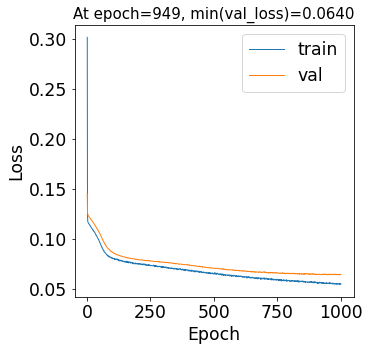

In [16]:
plt.figure(figsize=(5,5))
plt.plot(loss[:,0],loss[:,1],label="train")
plt.plot(loss[:,0],loss[:,2],label="val")
min_epoch, min_loss = min(enumerate(loss[:,2]), key=itemgetter(1))
plt.title("At epoch=%2d, min(val_loss)=%.4f" % (min_epoch+1, min_loss), size=15)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [12]:
del model

In [17]:
epoch = min_epoch
hdf5name = sorted(os.listdir(filepath))[epoch]
model.load_weights(filepath+hdf5name)
# model = keras.models.load_model(filepath+hdf5name, custom_objects={"log_mse_loss":log_mse_loss})

print(hdf5name)
print(model.evaluate(data_lst["train"][0],data_lst["train"][1],batch_size=100, verbose=0)[0])
print(model.evaluate(data_lst["vald"][0],data_lst["vald"][1],batch_size=100, verbose=0)[0])
print(model.evaluate(data_lst["test"][0],data_lst["test"][1],batch_size=100, verbose=0)[0])



948-0.0553-0.7543-0.0641-0.7224.hdf5


WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


0.5316070210244622
0.7223857959570993
0.563784900533574


In [18]:
pathway = "/home/groups/song/songlab2/dnewton2/FinalSim3/model/comparison.csv"
best_sequence = pd.read_csv(pathway)
best_seq_array = []
for row in best_sequence.itertuples():
    seq_array = seq2vec(row.best_seq).reshape((1,47,4))
    indicator = np.zeros((1,47,1))
    indicator[:,21-row.pbsl:21+row.rttl,:]=1
    best_seq_array.append(np.concatenate([seq_array,indicator], axis=2))
best_seq_array = np.array(best_seq_array)

best_sequence

,pbsl,rttl,qa,qv,best_seq,ER_of_best_seq,avg_eval,std_eval,avg_iter_of_best,std_iter_of_best,avg_expected_deltaER_at_best,std_expected_deltaER_at_best,avg_accept_at_best,std_accept_at_best,max_iter,avg_expected_deltaER_at_last,std_expected_deltaER_at_last,avg_accept_at_last,std_accept_at_last
0,7,10,1.15,1.3,CGCAGTAGCACCGGGGCTCGCCAGAGGTTTGGGATGACTGCCATCTG,55.418520,54.653943,1.510874,15212.52,11977.479835,-0.004163,0.002823,0.953158,0.021847,50000.0,0.001512,0.002792,0.992476,0.009777
1,7,12,1.15,1.3,CGCAGTAGCACCGGGGCTCGCCAGAGGTTTGAGATGACGGCCATCTG,53.879784,53.347724,1.582817,8203.48,3353.311332,-0.005113,0.002625,0.946212,0.010853,50000.0,0.001307,0.002627,0.993403,0.011446
2,7,15,1.15,1.3,CGCAGTAGCACCGGGGCTCGCCAGAGGTTGGCAGGTCCTCCGACCTG,48.887768,48.013726,1.421638,12000.12,8888.816953,-0.004941,0.002303,0.944495,0.012726,50000.0,0.000784,0.002347,0.989135,0.012994
3,7,20,1.15,1.3,CGCAGTAGCACCGGGGCTCGCCAGAGGTTTGCCGGTCCTCCGATATG,42.864044,42.297028,1.277689,15508.28,8383.970317,-0.004626,0.001482,0.939426,0.008910,50000.0,0.001144,0.003827,0.986482,0.015412
4,9,10,1.15,1.3,CGCAGTAGCTCCGGGGCTCGCCAGAGGTTTGGGATGACTGCCATCTG,57.322544,56.837064,1.618707,19016.92,12737.372187,-0.003076,0.001994,0.959987,0.018787,50000.0,0.001055,0.002546,0.988338,0.014205
5,9,12,1.15,1.3,CGCAGTAGCTCCGGGGCTCGCCAGAGGTTTGAGATGACGGCCATCTG,55.783800,55.221550,1.708915,6715.24,2690.960264,-0.005628,0.002500,0.943742,0.010919,50000.0,0.000753,0.002022,0.990199,0.011143
6,9,15,1.15,1.3,CGCAGTAGCTCCGGGGCTCGCCAGAGGTTGGCAGGTCCTCCGACCTG,50.791790,50.114720,1.739262,12879.12,11012.465080,-0.004782,0.001996,0.945431,0.012306,50000.0,0.000226,0.001549,0.990157,0.012444
7,9,20,1.15,1.3,CGCAGTAGCTCCGGGGCTCGCCAGAGGTTTGCCGGTCCTCCGATATG,44.927814,44.337989,1.434995,12175.44,5275.416079,-0.004953,0.001553,0.939025,0.008771,50000.0,0.001560,0.002695,0.994531,0.008640
8,11,10,1.15,1.3,CGCAGTAGCACCGGGGCTCGCCAGAGGTTTGGGATGACTGCCATCTG,57.709282,57.007277,1.620218,13602.84,10437.868249,-0.003790,0.003424,0.961004,0.025901,50000.0,0.001053,0.002221,0.991652,0.012307
9,11,12,1.15,1.3,CGCAGTAGCACCGGGGCTCGCCAGAGGTTTGAGATGACGGCCATCTG,56.170536,55.722314,1.494651,7538.44,2986.329601,-0.004679,0.001526,0.950023,0.008026,50000.0,0.001082,0.002443,0.992153,0.009287


,pbsl,rttl,qa,qv,best_seq,ER_of_best_seq,avg_eval,std_eval,avg_iter_of_best,std_iter_of_best,avg_expected_deltaER_at_best,std_expected_deltaER_at_best,avg_accept_at_best,std_accept_at_best,max_iter,avg_expected_deltaER_at_last,std_expected_deltaER_at_last,avg_accept_at_last,std_accept_at_last
0,7,10,1.15,1.3,GGCAGTAGGTCCAGGGCTGGCCAGAGGTTTGGGCCGTCTGCCAGGGT,55.000740,54.398343,1.660756,11380.92,8015.670432,0.034245,0.003967,1.0,0.0,49999.0,0.048631,0.009374,1.0,0.0
1,7,12,1.15,1.3,GGCAGTAGGTCCAGGGCTGGCCAGAGGTTTGAGATGACTGCCAGGGG,54.085785,53.669416,1.408456,9156.08,5350.720474,0.021863,0.002370,1.0,0.0,49999.0,0.030941,0.005481,1.0,0.0
2,7,15,1.15,1.3,GGCAGTAGGTCCAGGGCTGGCCAGAGGTTTGAGCTGTCTGCCAGGGT,48.636420,48.149485,1.682973,8577.64,4169.237406,0.016556,0.002925,1.0,0.0,49999.0,0.030082,0.008685,1.0,0.0
3,7,20,1.15,1.3,GGCAGTAGGTCCAGGGCTGGCCAGAGGTTTGAGCTGTCTCCACGAGC,44.079933,43.584826,1.358217,14157.12,10273.901099,0.030920,0.003111,1.0,0.0,49999.0,0.040225,0.006856,1.0,0.0
4,9,10,1.15,1.3,GGCAGAAGTGCCGGGGCTGGCCAGAGGTTTGGGCCGTCTGCCAGGGT,57.543770,57.016489,1.331259,12098.56,9466.554394,0.037540,0.001823,1.0,0.0,49999.0,0.043474,0.004443,1.0,0.0
5,9,12,1.15,1.3,GGCAGAAGTGCCGGGGCTGGCCAGAGGTTTGAGATGACTGCCAGGGA,56.628815,56.092083,1.773185,7556.12,2682.382155,0.025841,0.001616,1.0,0.0,49999.0,0.030216,0.004545,1.0,0.0
6,9,15,1.15,1.3,GGCAGAAGTGCCGGGGCTGGCCAGAGGTTTGAGCTGTCTGCCAGGGC,51.179450,50.589308,1.500212,9520.84,4076.363180,0.021682,0.002745,1.0,0.0,49999.0,0.028833,0.008575,1.0,0.0
7,9,20,1.15,1.3,GGCAGAAGTGCCGGGGCTGGCCAGAGGTTTGAGCTGTCTCCACGAGG,46.622963,46.118621,1.545597,9464.52,4320.744020,0.027031,0.001772,1.0,0.0,49999.0,0.035863,0.005047,1.0,0.0
8,11,10,1.15,1.3,GGCAGTGGTTCCGGGGCTGGCCAGAGGTTTGGGCCGTCTGCCAGGGA,57.612570,57.093090,1.601357,8813.28,5576.706752,0.034173,0.002563,1.0,0.0,49999.0,0.041419,0.005078,1.0,0.0
9,11,12,1.15,1.3,GGCAGTGGTTCCGGGGCTGGCCAGAGGTTTGAGATGACTGCCAGGGC,56.697617,56.190702,1.647598,4424.48,1801.149236,0.021004,0.002382,1.0,0.0,49999.0,0.031018,0.004121,1.0,0.0


In [17]:
best_seq_array.shape

(24, 1, 47, 5)

In [23]:
PBSL = 13
RTTL = 15
indx = np.argwhere((data_lst["test"][0][:,0,21-PBSL,4]==1) & (data_lst["test"][0][:,0,21-PBSL-1,4]==0) \
           & (data_lst["test"][0][:,0,21+RTTL-1,4]==1) & (data_lst["test"][0][:,0,21+RTTL,4]==0))
test_lst = [data_lst["test"][0][indx.flatten(),:,:,:], ERs["test"][indx.flatten()]]
[inpt,outpt] = test_lst

out_pred = model.predict(inpt)
cut = np.sort(out_pred.flatten())[-len(out_pred)//10]
inpt_hi_indices = np.nonzero(out_pred.squeeze() >= cut )
print("Input_hi_indices:", inpt_hi_indices[0])
inpt_hi = inpt[inpt_hi_indices].copy()
print("Input_hi_shape:", inpt_hi.shape)

Input_hi_indices: [ 11  12  18  30  37  70  75  82  83  85  87  94  96  99 108 113 149 169
 174]
Input_hi_shape: (19, 1, 47, 5)


In [68]:
calcObjective = K.function(inputs= [model.input , K.learning_phase()] , outputs= [model.layers[len(model.layers)-2].output])

layerIdx = len(model.layers)-2
scaleA = model.layers[layerIdx +1].kernel[:,0].eval()

k=0
for PBSL in [7,9,11,13,15,17]:
    for RTTL in [10,12,15,20]:
        sqrt = np.zeros((47,4))
        seq0 = best_seq_array[k].reshape((1,1,47,5))
        for i in range(47):
            for j in range(4):
                seq1 = seq0.copy()
                seq1[0,0,i,:4] = 0
                seq1[0,0,i,j] = 1
                pen0 = calcObjective([seq0,0])
                pen1 = calcObjective([seq1,0])
                sqrt[i,j] = np.sqrt(np.sum((scaleA*(pen0[0]-pen1[0]))**2))
        beta = -np.log(0.05)/np.median(sqrt.flatten()[sqrt.flatten().nonzero()])
        print(k, PBSL, RTTL, beta)
        k+=1
        


0 7 10 3.8672003001722035
1 7 12 3.543409826656244
2 7 15 3.971368516937554
3 7 20 3.9297405456217067
4 9 10 4.031440831790407
5 9 12 3.923657181635365
6 9 15 4.1355153818717305
7 9 20 4.088694439574945
8 11 10 3.9502685886614897
9 11 12 3.8347377187289218
10 11 15 4.011395787757967
11 11 20 3.967249261979567
12 13 10 4.045563289146615
13 13 12 3.9526387992723873
14 13 15 4.073863421270913
15 13 20 4.054056462933964
16 15 10 4.118338065464256
17 15 12 4.150630879738548
18 15 15 4.223439168780427
19 15 20 4.195453124085074
20 17 10 4.499746155967124
21 17 12 4.478851453861916
22 17 15 4.499750184561331
23 17 20 4.578427513097392


In [94]:
row = best_sequence.loc[0]
row.best_seq, row.pbsl

('CGCAGTAGCACCGGGGCTCGCCAGAGGTTTGGGATGACTGCCATCTG', 7)

In [5]:
pathway = "/home/groups/song/songlab2/dnewton2/FinalSim3/model/comparison.csv"
best_sequence = pd.read_csv(pathway)
best_seq_array = []
for row in best_sequence.itertuples():
    seq_array = seq2vec(row.best_seq).reshape((1,47,4))
    indicator = np.zeros((1,47,1))
    indicator[:,21-row.pbsl:21+row.rttl,:]=1
    best_seq_array.append(np.concatenate([seq_array,indicator], axis=2))
best_seq_array = np.array(best_seq_array)

In [6]:
def possible_cases(k):
    N = 3**k
    for i in range(k):
        N *= 47-i
    return N

In [7]:
for i in range(47):
    print(i, possible_cases(i))

0 1
1 141
2 19458
3 2626830
4 346741560
5 44729661240
6 5635937316240
7 693220289897520
8 83186434787702400
9 9732812870161180800
10 1109540667198374611200
11 123159014059019581843200
12 13301173518374114839065600
13 1396623219429282058101888000
14 142455568381786769926392576000
15 14103101269796890222712865024000
16 1353897721900501461380435042304000
17 125912488136746635908380458934272000
18 11332123932307197231754241304084480000
19 985894782110726159162618993455349760000
20 82815161697300997369659995450249379840000
21 6708028097481380786942459631470199767040000
22 523226191603547701381511851254675581829120000
23 39241964370266077603613388844100668637184000000
24 2825421434659157587460163996775248141877248000000
25 194954078991481873534751315777492121789530112000000
26 12866969213437803653293586841314480038108987392000000
27 810619060446581630157495971002812242400866205696000000
28 48637143626794897809449758260168734544051972341760000000
29 2772317186727309175138636220829617869010962

In [36]:
calcObjective = K.function(inputs= [model.input , K.learning_phase()] , outputs= [model.layers[len(model.layers)-2].output])

layerIdx = len(model.layers)-2
scaleA = model.layers[layerIdx +1].kernel[:,0].eval()

k=14
PBSL=13
RTTL=15

# for PBSL in [7,9,11,13,15,17]:
#     for RTTL in [10,12,15,20]:

sqrt2 = []
ER2 = []
seq0 = best_seq_array[k].reshape((1,1,47,5))
for i0 in range(47):
    for i1 in range(i0+1,47):
        for j0 in range(4):
            for j1 in range(4):
                if i0==25 or i0==26: continue
                if i1==25 or i1==26: continue
                if j0==np.argmax(seq0[0,0,i0,:4]):continue
                if j1==np.argmax(seq0[0,0,i1,:4]):continue
                seq1 = seq0.copy()
                seq1[0,0,i0,:4] = 0
                seq1[0,0,i0,j0] = 1
                seq1[0,0,i1,:4] = 0
                seq1[0,0,i1,j1] = 1
                pen0 = calcObjective([seq0,0])
                pen1 = calcObjective([seq1,0])
                sqrt2.append(np.sqrt(np.sum((scaleA*(pen0[0]-pen1[0]))**2)))
                ER2.append(model.predict(seq1)[0,0])
beta = -np.log(0.05)/np.median(sqrt.flatten()[sqrt.flatten().nonzero()])
print(k, PBSL, RTTL, beta)
k+=1
        


14 13 15 4.300206439795746


In [117]:
calcObjective = K.function(inputs= [model.input , K.learning_phase()] , outputs= [model.layers[len(model.layers)-2].output])
layerIdx = len(model.layers)-2
scaleA = model.layers[layerIdx +1].kernel[:,0].eval()
sqrt = []
ER = []
for i in range(47):
    for j in range(4):
        if i==25 or i==26: continue
        if j==np.argmax(seq0[0,0,i,:4]):continue
        seq1 = seq0.copy()
        seq1[0,0,i,:4] = 0
        seq1[0,0,i,j] = 1
        pen0 = calcObjective([seq0,0])
        pen1 = calcObjective([seq1,0])
        sqrt.append(np.sqrt(np.sum((scaleA*(pen0[0]-pen1[0]))**2)))
        ER.append(model.predict(seq1)[0,0])

In [127]:
from sklearn.linear_model import LinearRegression


reg = LinearRegression().fit(np.array(sqrt2+sqrt_rand).reshape((-1,1)), ER2+ER_rand)
print(reg.score(np.array(sqrt2+sqrt_rand).reshape((-1,1)), ER2+ER_rand))
print(reg.coef_)
print(reg.intercept_)

0.999591747410589
[-1.6258813]
50.972527


In [123]:
reg = LinearRegression().fit(np.array(sqrt).reshape((-1,1)), ER)
print(reg.score(np.array(sqrt).reshape((-1,1)), ER))
print(reg.coef_)
print(reg.intercept_)

0.9900786542935279
[-1.6533437]
51.053364


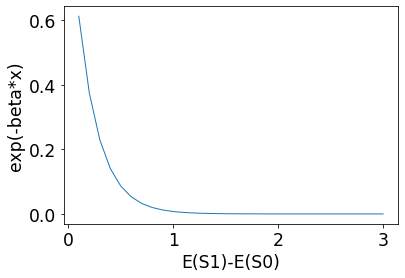

In [126]:
X = np.arange(0.1, 3.1, 0.1)
plt.plot(X, np.exp(-4.9*X))
plt.ylabel("exp(-beta*x)")
plt.xlabel("E(S1)-E(S0)")
plt.show()

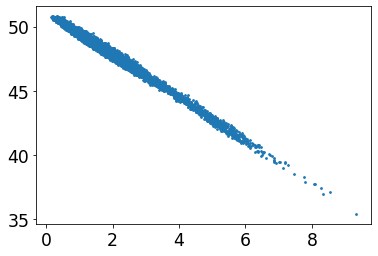

In [37]:
plt.scatter(sqrt2,ER2,s=3)
plt.show()

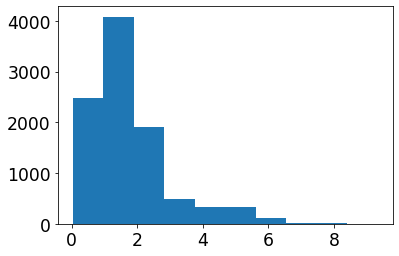

In [30]:
plt.hist(sqrt2)
plt.show()

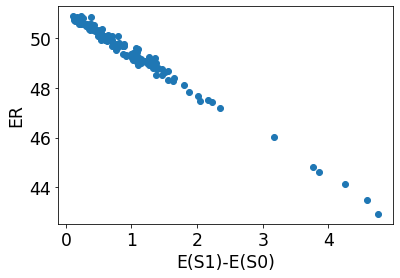

In [121]:
plt.scatter(sqrt,ER)
plt.ylabel("ER")
plt.xlabel("E(S1)-E(S0)")
plt.show()

In [35]:
ER>50.97

array([[False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [ True, False, False,  True],
       [False,  True, False, False],
 

In [33]:
sqrt

array([[0.52427208, 0.        , 0.11322144, 0.55432475],
       [0.64509678, 0.75139672, 0.        , 0.60546392],
       [0.59651953, 0.        , 0.19933228, 0.49180478],
       [0.        , 0.53493458, 0.20515358, 0.41355628],
       [1.40594721, 2.23385787, 0.        , 2.17226005],
       [1.01733947, 1.27423882, 0.88420749, 0.        ],
       [0.        , 0.65703607, 0.3825303 , 1.46488249],
       [1.37579906, 0.70215023, 0.        , 1.08436346],
       [0.57212788, 0.15172249, 0.22409263, 0.        ],
       [0.26100358, 0.89141786, 0.42783603, 0.        ],
       [1.07171273, 0.        , 0.99487633, 1.63231039],
       [1.32606483, 0.        , 0.59656686, 1.06710541],
       [0.69664848, 0.80424833, 0.        , 0.86640394],
       [1.31772649, 0.58080804, 0.        , 1.27252805],
       [0.44216222, 1.06145787, 0.        , 0.87648296],
       [0.7258243 , 0.64017552, 0.        , 0.72752613],
       [1.55683517, 0.        , 1.02357185, 1.65438771],
       [1.50589299, 0.61293888,

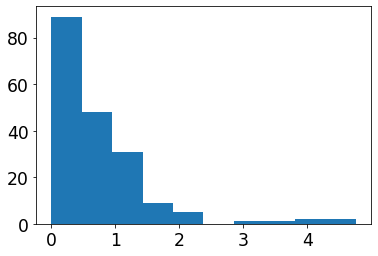

In [21]:
plt.hist(sqrt.flatten())
plt.show()

In [46]:
def generate_rand_seq(PBSL,RTTL):
    rand_seq = np.zeros((47,5))
    for i,j in enumerate(np.random.randint(0,4,47)):
        rand_seq[i,j] = 1
    rand_seq[25,:4] = np.array([0,0,1,0])
    rand_seq[26,:4] = np.array([0,0,1,0])
    rand_seq[21-PBSL:21+RTTL,4] = 1
    return rand_seq

In [52]:
k=14
PBSL=13
RTTL=15

sqrt_rand=[]
ER_rand=[]

seq0 = best_seq_array[k].reshape((1,1,47,5))
pen0 = calcObjective([seq0,0])
for i in range(10**4):
    seq1 = generate_rand_seq(PBSL,RTTL).reshape((1,1,47,5))
    pen1 = calcObjective([seq1,0])
    sqrt_rand.append(np.sqrt(np.sum((scaleA*(pen0[0]-pen1[0]))**2)))
    ER_rand.append(model.predict(seq1)[0,0])

In [60]:
def prob_lt_x(beta,x):
    return (1-np.exp(-beta*x))

In [98]:
prob_lt_x(3,1), 2*np.log(10)/(1/1.6), np.log(20)/(1/1.6), np.log(0.05)*reg.coef_[0]

(0.950212931632136, 7.368272297580947, 4.7931716376863855, 4.903984691422219)

In [88]:
scipy.stats.pearsonr(sqrt2,ER2), scipy.stats.pearsonr(sqrt.flatten(),ER.flatten())

((-0.9954830301041789, 0.0), (-0.9895225168986862, 2.7457879912159397e-158))

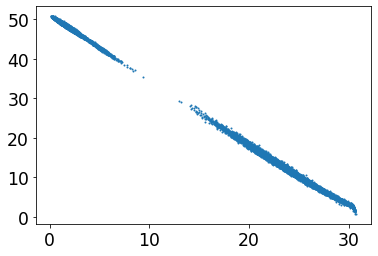

In [55]:
plt.scatter(sqrt2+sqrt_rand,ER2+ER_rand, s=1)
plt.show()

In [138]:
### maxEnt
t0 = time.time()

k=0
indices_allowed = np.concatenate([np.arange(0,25,1, dtype = np.int64), np.arange(27, 47, dtype = np.int64)]) 
layer4Sampler =layerSampler(model ,layerIdx = len(model.layers)-2,beta = 3 , mu = 0.0 , outputUnitIdxs =(1,) )
samplesByInput = layer4Sampler.sample( interpInputs = best_seq_array[k:k+1,:,:,:], \
                                      indices_allowed = indices_allowed, \
                                      nbSteps = 10**4, samplePeriod =10**2, chainsPerInput=1000 )

print(time.time()-t0)


sampling using similarity of represtation at layer 85 of type <class 'keras.layers.core.Dense'>


/home/apps/software/jupyter/1.0.0-IGB-gcc-4.9.4-Python-3.6.1/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=/input_1, outputs=Elemwise{m...)`


698.5794200897217


In [130]:
samplesByInput.shape

(1, 5000, 47)

In [135]:
oneHotArr = MEutils.NTidx_to_1Hot(samplesByInput[-4500:,])
NTcounts = np.sum(oneHotArr , axis=1)
NTfreqs = NTcounts / np.sum(NTcounts, axis = -1, keepdims=True).astype(float)
 
# pickle.dump(NTfreqs, open("../GABPAmotif/maxEnt_motif/test22/epoch9/NTfreqs/%d.pkl" % N0,"wb"))
# pickle.dump(samplesByInput, open("../GABPAmotif/maxEnt_motif/test43/epoch15/beta100/samplesByInput/%03d.pkl" % N0,"wb"))


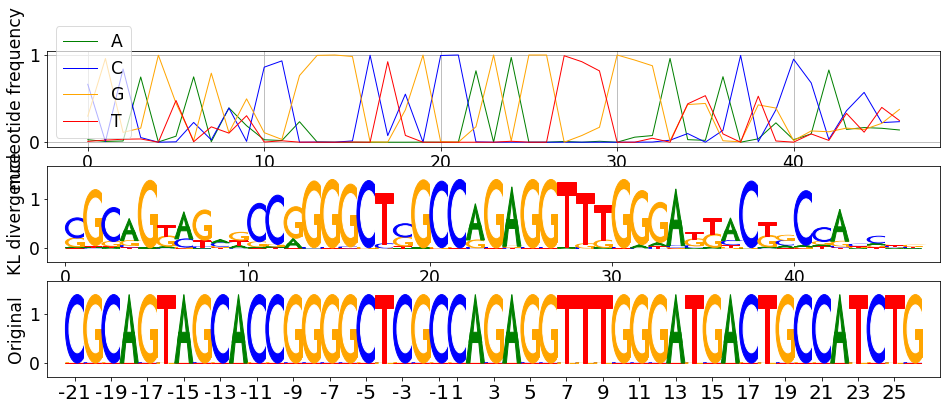

In [132]:
k=0

figsize = (16, 6)
fig ,axes = plt.subplots( figsize = figsize , nrows= 3 , ncols=1 )

MEutils.plotSingleNT_marginalDistrib(NTfrequencies= NTfreqs[0,:,:], ax = axes[0])
# axes[0].set_title("ER_obs = %d, ER_pred = %.2f" % (y, ybar),fontsize = 'xx-large')

plot_sNTdistrib(samples=NTfreqs[0,:,:].transpose(), ax = axes[1] , motif= True) 

plot_sNTdistrib(samples=best_seq_array[k,0,:,:4].transpose(), ax = axes[2] , motif= True) 
axes[2].set_ylabel("Original")

axes[2].set_xticks(np.concatenate([np.arange(0,21,2)+.5,np.arange(21,47,2)+.5]))
axes[2].set_xticklabels(np.concatenate([np.arange(-21,0,2),np.arange(1,27,2)]), fontdict={"fontsize":20})
# fig.savefig(filepath1+"%d_ERobs_%d_ERpred_%.2f.png" % (k, int(y), ybar),  bbox_inches = "tight"  )
# plt.close("all")
plt.show()

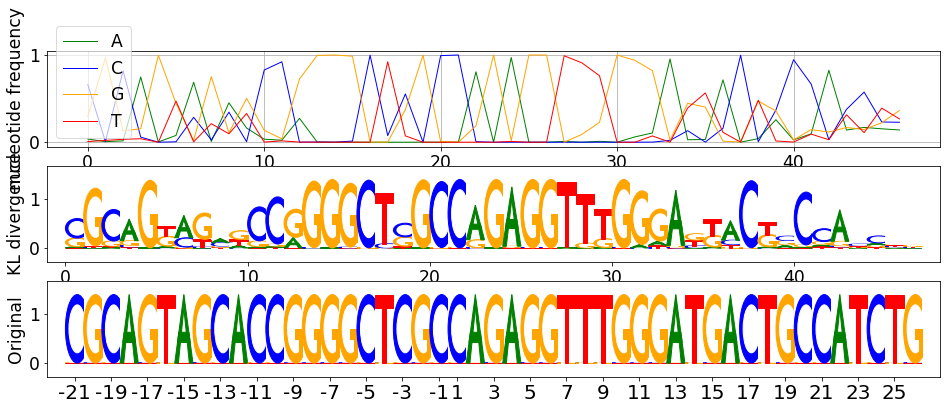

In [81]:
k=0

figsize = (16, 6)
fig ,axes = plt.subplots( figsize = figsize , nrows= 3 , ncols=1 )

MEutils.plotSingleNT_marginalDistrib(NTfrequencies= NTfreqs[0,:,:], ax = axes[0])
# axes[0].set_title("ER_obs = %d, ER_pred = %.2f" % (y, ybar),fontsize = 'xx-large')

plot_sNTdistrib(samples=NTfreqs[0,:,:].transpose(), ax = axes[1] , motif= True) 

plot_sNTdistrib(samples=best_seq_array[k,0,:,:4].transpose(), ax = axes[2] , motif= True) 
axes[2].set_ylabel("Original")

axes[2].set_xticks(np.concatenate([np.arange(0,21,2)+.5,np.arange(21,47,2)+.5]))
axes[2].set_xticklabels(np.concatenate([np.arange(-21,0,2),np.arange(1,27,2)]), fontdict={"fontsize":20})
# fig.savefig(filepath1+"%d_ERobs_%d_ERpred_%.2f.png" % (k, int(y), ybar),  bbox_inches = "tight"  )
# plt.close("all")
plt.show()

In [26]:
t0 = time.time()

        print(pbsl,rttl,time.time()-t0)

7 10 0.14522385597229004
7 12 0.2712275981903076
7 15 0.4078786373138428
7 20 0.48285365104675293
9 10 0.5957155227661133
9 12 0.7082014083862305
9 15 0.7815303802490234
9 20 0.8890135288238525
11 10 1.037581205368042
11 12 1.1373584270477295
11 15 1.2222485542297363
11 20 1.346503496170044
13 10 1.442098617553711
13 12 1.5067825317382812
13 15 1.5798325538635254
13 20 1.6779704093933105
15 10 1.800457239151001
15 12 1.875321626663208
15 15 1.9552438259124756
15 20 2.065566062927246
17 10 2.1745662689208984
17 12 2.2706174850463867
17 15 2.3988864421844482
17 20 2.5025618076324463


In [105]:
### load maxEnt result
samplesByInput_dict = {}
NTfreqs_dict = {}
k=0
for pbsl in [7,9,11,13,15,17]:
    for rttl in [10,12,15,20]:
        samplesByInput_dict[pbsl,rttl] = pickle.load(open("./SA_maxEnt/samplesByInput_%d.pkl" % k,"rb"))
        oneHotArr = MEutils.NTidx_to_1Hot(samplesByInput_dict[pbsl,rttl][:,10000:,:]) # 10% burn-in
        NTcounts = np.sum(oneHotArr , axis=1)
        NTfreqs_dict[pbsl,rttl] = NTcounts / np.sum(NTcounts, axis = -1, keepdims=True).astype(float)
        k+=1
        

In [106]:
pickle.dump(NTfreqs_dict,open("./codes_for_figures/maxEnt_result.pkl","wb"))

In [137]:
NTfreqs_dict[PBSL,RTTL]

array([[[6.25444444e-02, 5.78977778e-01, 3.34777778e-01, 2.37000000e-02],
        [3.18777778e-02, 2.44666667e-02, 8.89933333e-01, 5.37222222e-02],
        [4.37555556e-02, 6.36877778e-01, 2.48188889e-01, 7.11777778e-02],
        [6.94655556e-01, 5.20555556e-02, 1.58777778e-01, 9.45111111e-02],
        [3.65555556e-03, 0.00000000e+00, 9.96311111e-01, 3.33333333e-05],
        [1.45444444e-02, 3.61111111e-03, 2.09777778e-02, 9.60866667e-01],
        [8.84966667e-01, 4.17444444e-02, 7.23333333e-02, 9.55555556e-04],
        [4.02222222e-03, 3.32222222e-02, 9.49877778e-01, 1.28777778e-02],
        [4.08888889e-02, 1.89144444e-01, 1.90044444e-01, 5.79922222e-01],
        [2.78633333e-01, 2.01888889e-02, 9.93444444e-02, 6.01833333e-01],
        [1.73222222e-02, 9.68777778e-01, 1.30222222e-02, 8.77777778e-04],
        [1.74444444e-03, 9.42688889e-01, 4.89555556e-02, 6.61111111e-03],
        [6.44666667e-02, 3.20222222e-02, 8.66222222e-01, 3.72888889e-02],
        [1.78888889e-03, 1.79144444e-0

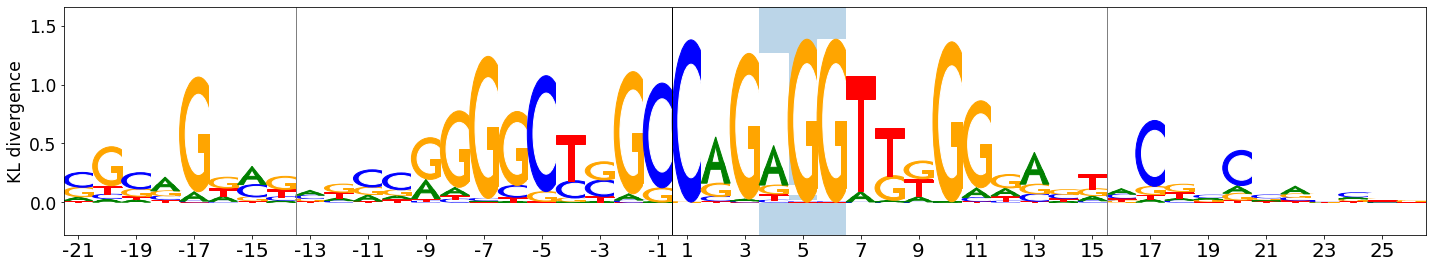

In [136]:
# NTfreqs_dict = pickle.load(open("./codes_for_figures/maxEnt_result.pkl","rb"))

### Choose PBSL and RTTL
PBSL=13
RTTL=15
 
plotMotif = True
fig , ax = plt.subplots(figsize = (20,4), nrows = 1 , ncols=1)
# plot_sNTdistrib(samples=NTfreqs_dict[PBSL,RTTL].copy().squeeze().transpose(), ax = ax , motif= plotMotif)
# plot_sNTdistrib(samples=best_seq_array[14,0,:,:4].transpose(), ax = ax , motif= plotMotif)

plot_sNTdistrib(samples=NTfreqs[0,:,:].transpose(), ax = ax , motif= plotMotif)


L=47
xlim = (0,L)
ax.set_xlim(xlim)
ax.set_xticks(np.concatenate([np.arange(0,21,2)+.5,np.arange(21,L,2)+.5]))
ax.set_xticklabels(np.concatenate([np.arange(-21,0,2),np.arange(1,27,2)]), fontdict={"fontsize":20})
ax.fill_betweenx(list(ax.get_ylim()),L-23,L-20, alpha=0.3)
ax.vlines(L-26, ax.get_ylim()[0], ax.get_ylim()[1], "k")
ax.vlines(L-26-PBSL, ax.get_ylim()[0], ax.get_ylim()[1], "grey")
ax.vlines(L-26+RTTL, ax.get_ylim()[0], ax.get_ylim()[1], "grey")

fig.tight_layout()
fig.subplots_adjust(top = 0.92)
plt.show()

In [66]:
NTfreqs.shape

(1, 47, 4)

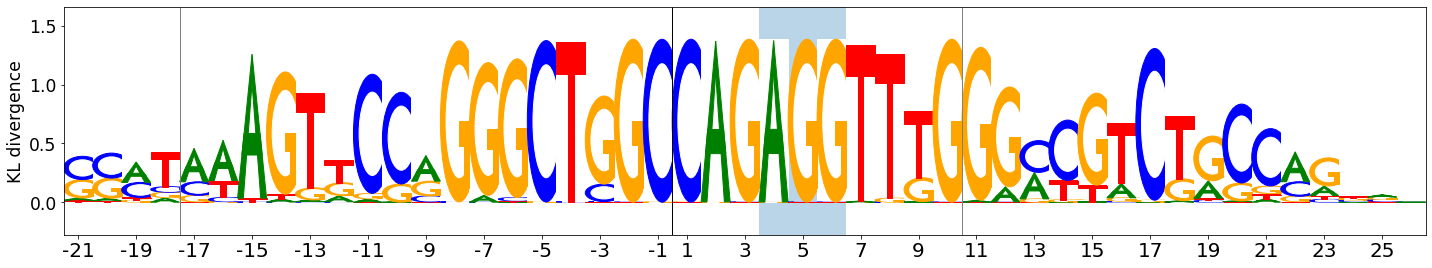

In [36]:
interpInputs.

SyntaxError: invalid syntax (<ipython-input-36-14a8c0defe4c>, line 1)

In [42]:
tmpfunc = Model(input = model.input , output= model.layers[len(model.layers)-2].output )

/home/apps/software/jupyter/1.0.0-IGB-gcc-4.9.4-Python-3.6.1/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=/input_4, outputs=Elemwise{m...)`
  """Entry point for launching an IPython kernel.


In [43]:
tmpfunc(test_lst[0][0:20,:])

ValueError: Layer model_16 was called with an input that isn't a symbolic tensor. Received type: <class 'numpy.ndarray'>. Full input: [array([[[[1., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0.],
         ...,
         [0., 0., 1., 0., 0.],
         [0., 1., 0., 0., 0.],
         [0., 0., 0., 1., 0.]]],


       [[[1., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [1., 0., 0., 0., 0.],
         ...,
         [0., 0., 1., 0., 0.],
         [0., 1., 0., 0., 0.],
         [0., 0., 0., 1., 0.]]],


       [[[1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0.],
         ...,
         [0., 0., 1., 0., 0.],
         [0., 1., 0., 0., 0.],
         [0., 0., 0., 1., 0.]]],


       ...,


       [[[0., 1., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         ...,
         [0., 0., 1., 0., 0.],
         [0., 1., 0., 0., 0.],
         [0., 0., 0., 1., 0.]]],


       [[[0., 0., 0., 1., 0.],
         [0., 1., 0., 0., 0.],
         [0., 0., 0., 1., 0.],
         ...,
         [0., 0., 1., 0., 0.],
         [0., 1., 0., 0., 0.],
         [0., 0., 0., 1., 0.]]],


       [[[0., 0., 0., 1., 0.],
         [0., 0., 0., 1., 0.],
         [0., 0., 0., 1., 0.],
         ...,
         [0., 0., 1., 0., 0.],
         [0., 1., 0., 0., 0.],
         [0., 0., 0., 1., 0.]]]])]. All inputs to the layer should be tensors.

In [45]:
Model?

In [48]:
tmp = model.layers[0]

In [55]:
tmp.input_shape

(None, 1, 47, 5)

In [52]:
model.layers[len(model.layers)-2].output

Elemwise{mul,no_inplace}.0

In [19]:
calcObjective = K.function(inputs= [model.input , K.learning_phase()] , outputs= [model.layers[len(model.layers)-2].output])



In [28]:
calcObjective([best_seq_array[14].reshape((1,1,47,5)),0])

[array([[0.       , 0.       , 5.1319194, 0.       , 0.       , 0.       ,
         7.5518265, 0.       , 0.       , 4.601106 ]], dtype=float32)]

In [40]:
calcObjective = K.function(inputs= [model.input , K.learning_phase()] , outputs= [model.layers[len(model.layers)-2].output])

layerIdx = len(model.layers)-2
scaleA = model.layers[layerIdx +1].kernel[:,0].eval()

sqrt = np.zeros((47,4))
seq0 = best_seq_array[14].reshape((1,1,47,5))
for i in range(47):
    for j in range(4):
        seq1 = seq0.copy()
        seq1[0,0,i,:4] = 0
        seq1[0,0,i,j] = 1
        pen0 = calcObjective([seq0,0])
        pen1 = calcObjective([seq1,0])
        sqrt[i,j] = np.sqrt(np.sum((scaleA*(pen0[0]-pen1[0]))**2))
        
beta = -np.log(0.1)/np.median(sqrt.flatten()[sqrt.flatten().nonzero()])
print(beta)

In [41]:
with pd.option_context('display.max_rows', None,
                       'display.max_columns', 47,
                       'display.precision', 2,
                       ):
    print(pd.DataFrame(sqrt.transpose(),index=["A","C","G","T"]))

      0     1     2     3     4     5     6     7     8     9    10    11  \
A  0.40  0.60  0.53  0.00  1.43  0.67  0.00  1.61  0.68  0.27  0.89  1.37   
C  0.22  0.65  0.07  0.85  2.37  1.02  0.63  0.97  0.29  0.51  0.00  0.00   
G  0.00  0.00  0.27  0.67  0.00  0.83  0.44  0.00  0.57  0.49  0.74  0.38   
T  0.74  0.81  0.00  0.33  2.29  0.00  1.89  1.72  0.00  0.00  1.64  1.37   

     12    13    14    15    16    17    18    19    20    21    22    23  \
A  0.46  1.19  0.64  0.98  1.73  1.25  1.41  1.20  2.64  4.49  0.00  2.59   
C  0.52  0.91  0.97  0.62  0.00  0.60  0.34  1.88  0.00  0.00  1.01  2.69   
G  0.00  0.00  0.00  0.00  0.70  1.20  0.00  0.00  1.11  4.01  0.69  0.00   
T  0.70  1.47  1.35  0.78  1.45  0.00  0.74  4.75  4.23  4.01  1.91  2.84   

     24    25    26    27    28    29    30    31    32    33    34    35  \
A  0.00  0.15  0.16  0.32  1.75  1.26  1.04  0.00  1.21  0.10  0.73  0.31   
C  1.33  0.90  0.09  0.88  1.31  0.85  0.40  1.11  0.56  0.00  0.67  0.29 

In [49]:
np.median(sqrt.flatten()[sqrt.flatten().nonzero()])

0.7353541254997253

3.131260182200345


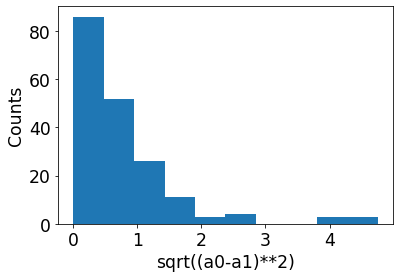

In [43]:
plt.hist(sqrt.flatten())#, bins=np.arange(0.1,1.8,0.1))
plt.xlabel("sqrt((a0-a1)**2)")
plt.ylabel("Counts")
plt.show()

In [42]:
pd.DataFrame?

In [67]:
Model0 = Model(input = model.input , output= model.layers[len(model.layers)-2].output ) 
interpInputs = T.tensor4(name = "interpInputs")

targetT = Model0(interpInputs) 

/home/apps/software/jupyter/1.0.0-IGB-gcc-4.9.4-Python-3.6.1/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=model_3/mo..., outputs=Elemwise{m...)`
  """Entry point for launching an IPython kernel.


In [40]:
targetT

In [27]:
layerIdx = len(model.layers)-2
a = model.layers[layerIdx +1].kernel[:,0]
a.eval()

array([-0.5464117 , -0.82218415,  2.8023949 , -0.5756891 , -0.46447283,
       -0.01230038,  3.2299604 , -0.17438157, -0.44813135,  2.5064626 ],
      dtype=float32)